In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [2]:
!pip install dill

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import warnings
from scipy.stats import norm
import pickle

# Read preprocessed train data

In [4]:
X_train_not_churned = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_not_churned')
y_train_not_churned = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_not_churned')['target_actual_profit']

# Read preprocessed test data

In [5]:
X_test_not_churned = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test_not_churned')
y_test_not_churned = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test_not_churned')['target_actual_profit']

# Create regression evaluation class

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [7]:
class RegressionEvaluation:
    def __init__(self, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred

    def r2(self):
        return r2_score(self.y_test, self.y_pred)

    def mean_absolute_error(self):
        return mean_absolute_error(self.y_test, self.y_pred)

    def mean_squared_error(self):
        return mean_squared_error(self.y_test, self.y_pred)

    def root_mean_squared_error(self):
        return np.sqrt(self.mean_squared_error())

    def residuals_plot(self):
        residuals = self.y_test - self.y_pred
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.y_pred, y=residuals)
        plt.axhline(0, color='red', linestyle='--', linewidth=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Predicted Values')
        plt.show()

    def predictions_vs_actual_plot(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, self.y_pred, alpha=0.5)
        plt.plot([self.y_test.min(), self.y_test.max()],
                 [self.y_test.min(), self.y_test.max()],
                 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predictions vs Actual Values')
        plt.show()

    def summary(self):
        print("R² Score:", self.r2())
        print("Mean Absolute Error:", self.mean_absolute_error())
        print("Mean Squared Error:", self.mean_squared_error())
        print("Root Mean Squared Error:", self.root_mean_squared_error())

---
# ***Pytorch Lightning Regression***
---

In [8]:
!pip install pytorch-lightning

# Import libraries for Lightning

In [9]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics import R2Score
from torch.optim import lr_scheduler

# Setting up the PyTorch Lightning Model

In [10]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_size, output_size, hidden=[1024, 512, 512, 64, 32, 16], adam_learning_rate = 0.001, drop_out_rate = 0.2, sheduler_factor = 0.1):
        super().__init__()
        self.adam_learning_rate = adam_learning_rate
        self.sheduler_factor = sheduler_factor
        self.drop_out_rate = drop_out_rate


        self.train_r2 = R2Score()
        self.val_r2 = R2Score()
        self.test_r2 = R2Score()

        all_layers = []
        for i in hidden:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU())
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(self.drop_out_rate))
            input_size = i
        all_layers.append(nn.Linear(hidden[-1], output_size))
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)

        pred = pred.squeeze(1)
        loss_class = nn.MSELoss()
        loss = loss_class(pred, y)

        self.log('train_loss', loss, prog_bar=True)
        self.train_r2(pred, y)

        return loss

    def train_epoch_end(self, outs):
        self.log('train_r2', self.train_r2.compute())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)
        pred = pred.squeeze(1)

        loss_class = nn.MSELoss()
        loss = loss_class(pred, y)

        self.log('val_loss', loss, prog_bar=True)
        self.val_r2(pred, y)

        return loss

    def on_validation_epoch_end(self):
        self.log('val_r2', self.val_r2.compute())

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.model(x)
        pred = pred.squeeze(1)

        loss_class = nn.MSELoss()
        loss = loss_class(pred, y)

        self.log('test_loss', loss, prog_bar=True)
        self.test_r2(pred, y)

        return loss

    def on_test_epoch_end(self):
        self.log('test_r2', self.test_r2.compute())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.adam_learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.sheduler_factor, patience=10)
        scheduler_config = {
            'scheduler': scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler_config]
    def predict(self, x):
        return self.forward(x)

# Setting up data loaders for Lightning

In [11]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [12]:
class DataModule(pl.LightningDataModule):
    def __init__(self, X_train, y_train, X_test, y_test, batch_size=64):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.batch_size = batch_size

    def setup(self, stage=None):
        X_train_tensor = torch.tensor(self.X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(self.y_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(self.X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(self.y_test.values, dtype=torch.float32)

        self.train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        self.test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Custom class for storing losses

In [13]:
class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_validation_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics['train_loss'].item() if 'train_loss' in trainer.callback_metrics else float('inf')
        val_loss = trainer.callback_metrics['val_loss'].item() if 'val_loss' in trainer.callback_metrics else float('inf')
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

# Grid search function for seaching best parameters

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

def grid_search(model_class, param_grid, data_module, num_epochs=30):
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    best_train_loss = float('inf')
    best_test_loss = float('inf')

    all_losses = []
    for lr in param_grid['learning_rate']:
        for drop_out in param_grid['drop_out_rate']:
            for scheduler in param_grid['sheduler_factor']:

                model = model_class(input_size=input_size,
                                    output_size=output_size,
                                    hidden=[1024, 512, 512, 64, 32, 16],
                                    adam_learning_rate=lr,
                                    drop_out_rate=drop_out,
                                    sheduler_factor=scheduler)

                loss_history = LossHistory()

                if torch.cuda.is_available():
                    trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=num_epochs,
                                         callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=True), loss_history])
                else:
                    trainer = pl.Trainer(max_epochs=num_epochs,
                                         callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=True), loss_history])

                trainer.fit(model, data_module)
                val_losses = loss_history.val_losses
                train_losses = loss_history.train_losses

                all_losses.append({
                    'params': {'learning_rate': lr, 'drop_out_rate': drop_out, 'sheduler_factor': scheduler},
                    'train_losses': train_losses,
                    'val_losses': val_losses
                })

                trainer.test(model, dataloaders=data_module.test_dataloader())
                test_loss = trainer.callback_metrics['test_loss'].item() if 'test_loss' in trainer.callback_metrics else float('inf')

                if min(val_losses) < best_val_loss:
                    best_val_loss = min(val_losses)
                    best_train_loss = train_losses[val_losses.index(min(val_losses))]
                    best_test_loss = test_loss
                    best_params = {'learning_rate': lr, 'drop_out_rate': drop_out, 'sheduler_factor': scheduler}
                    best_model = model

    best_losses = next((loss for loss in all_losses if loss['params'] == best_params), None)

    return best_model, best_params, best_val_loss, best_train_loss, best_test_loss, best_losses

In [15]:
input_size = X_train_not_churned.shape[1]
output_size = 1

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'drop_out_rate': [0.1, 0.2],
    'sheduler_factor': [0.1, 0.2]
}

# Data module class object

In [16]:
data_module = DataModule(X_train_not_churned, y_train_not_churned, X_test_not_churned, y_test_not_churned, 64)

# Train the model

In [17]:
best_model, best_params, best_val_loss, best_train_loss, best_test_loss, best_losses = grid_search(MultiLayerPerceptron, param_grid, data_module, num_epochs=30)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 9.134


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 8.987


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.621 >= min_delta = 0.0. New best score: 8.366


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.519 >= min_delta = 0.0. New best score: 7.846


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.078 >= min_delta = 0.0. New best score: 6.769


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.936 >= min_delta = 0.0. New best score: 5.833


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.484 >= min_delta = 0.0. New best score: 5.349


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 5.349. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     8.930694580078125     │
│          test_r2          │    0.7475467920303345     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 9.041


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.246 >= min_delta = 0.0. New best score: 8.795


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.200 >= min_delta = 0.0. New best score: 8.596


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.187 >= min_delta = 0.0. New best score: 8.409


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.461 >= min_delta = 0.0. New best score: 7.948


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.275 >= min_delta = 0.0. New best score: 5.673


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 5.673. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     6.891204833984375     │
│          test_r2          │     0.805199146270752     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 9.819


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.297 >= min_delta = 0.0. New best score: 9.521


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.427 >= min_delta = 0.0. New best score: 9.094


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.183 >= min_delta = 0.0. New best score: 7.911


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.301 >= min_delta = 0.0. New best score: 7.610


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 7.610. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     8.82878303527832      │
│          test_r2          │    0.7504276037216187     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 10.749


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.073 >= min_delta = 0.0. New best score: 9.676


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.240 >= min_delta = 0.0. New best score: 8.436


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.966 >= min_delta = 0.0. New best score: 7.470


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 7.470. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     8.054980278015137     │
│          test_r2          │    0.7723014950752258     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 8.559


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.348 >= min_delta = 0.0. New best score: 8.211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.163 >= min_delta = 0.0. New best score: 6.048


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 6.048. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │        17741856.0         │
│          test_r2          │       -501526.4375        │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 10.114


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.804 >= min_delta = 0.0. New best score: 9.310


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.231 >= min_delta = 0.0. New best score: 9.079


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.458 >= min_delta = 0.0. New best score: 8.621


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.117 >= min_delta = 0.0. New best score: 7.504


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 7.254


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 7.254. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     9.946842193603516     │
│          test_r2          │    0.7188222408294678     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 9.657


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.646 >= min_delta = 0.0. New best score: 9.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 9.011. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       152139.671875       │
│          test_r2          │     -4299.68994140625     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 9.350


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.352 >= min_delta = 0.0. New best score: 8.999


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 8.955


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.656 >= min_delta = 0.0. New best score: 8.299


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 8.299. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │        47232156.0         │
│          test_r2          │       -1335159.375        │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 763740.062


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 763740.062. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  3.1739095855895434e+21   │
│          test_r2          │  -8.972020160307973e+19   │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 170801789665280.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 170801789665280.000. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  2.6006733069903462e+17   │
│          test_r2          │    -7351593515089920.0    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 7409642.500


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 7409642.500. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2791323404861440.0     │
│          test_r2          │     -78905234948096.0     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | train_r2 | R2Score    | 0      | train
1 | val_r2   | R2Score    | 0      | train
2 | test_r2  | R2Score    | 0      | train
3 | model    | Sequential | 892 K  | train
------------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.571     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 713172096.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 713172096.000. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   6.95967506755234e+19    │
│          test_r2          │  -1.9673635772830843e+18  │
└───────────────────────────┴───────────────────────────┘

# Define the best model losses for trein and validation

In [18]:
train_losses = best_losses['train_losses']
val_losses = best_losses['val_losses']

# Visualization of train and validation loss

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

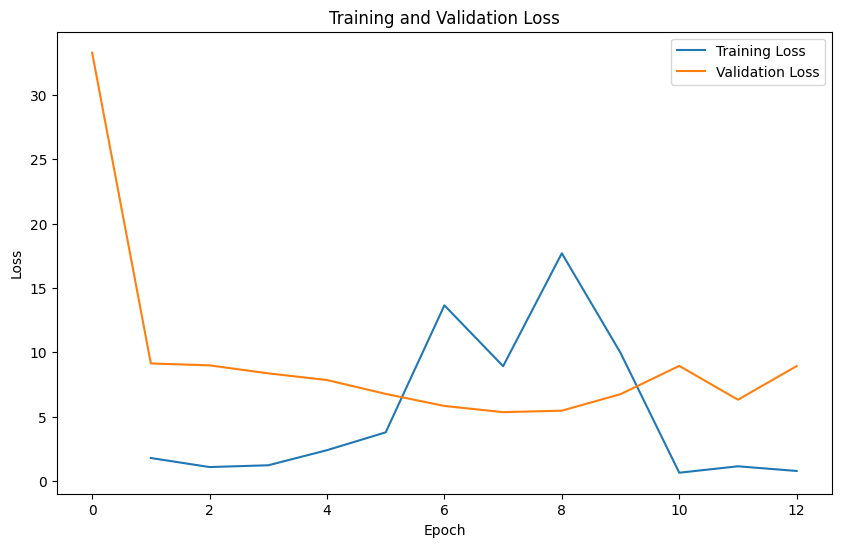

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt

# Create object of evaluation for test

In [29]:
pred = best_model.predict(torch.tensor(X_test_not_churned.values, dtype=torch.float32)).detach().numpy().flatten()

In [31]:
eval = RegressionEvaluation(y_test_not_churned, pred)

In [32]:
eval.summary()

R² Score: 0.7890507119104577
Mean Absolute Error: 0.990163437539423
Mean Squared Error: 7.462469270009439
Root Mean Squared Error: 2.7317520513416733


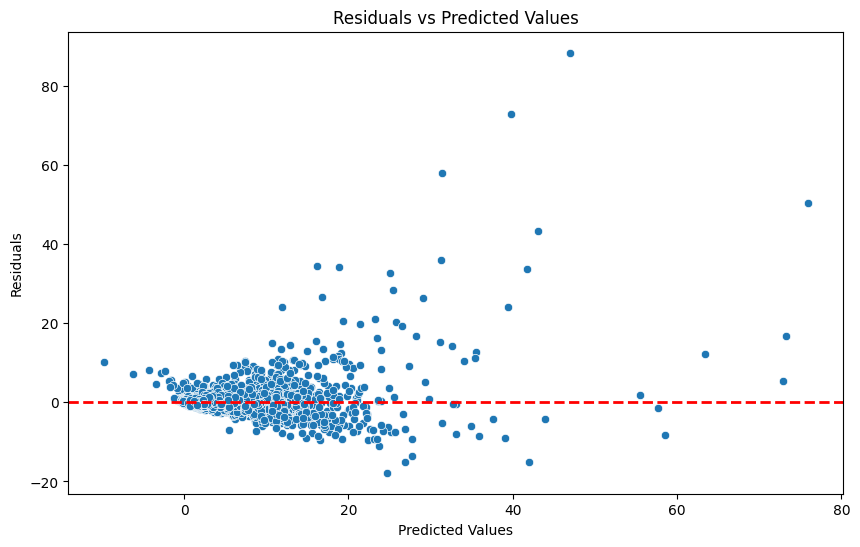

In [33]:
eval.residuals_plot()

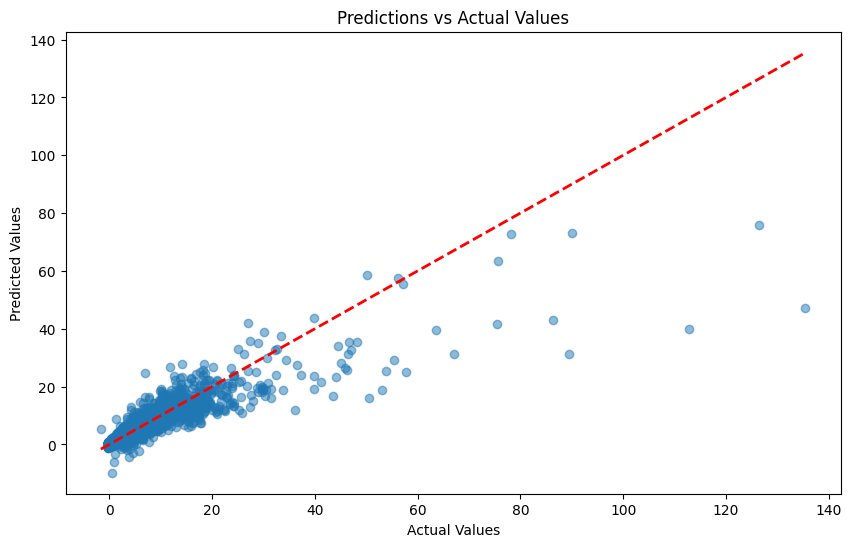

In [34]:
eval.predictions_vs_actual_plot()

In [36]:
eval.r2()

0.7890507119104577